In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import re

torch.manual_seed(42)
np.random.seed(42)

print("🚀 Regression Language Model (RLM) Tutorial")
print("=" * 60)

🚀 Regression Language Model (RLM) Tutorial


In [3]:
def generate_synthetic_data(n_samples=2000):
    """Generate synthetic text-to-number regression data"""

    templates = [
        ("The temperature is {} degrees", lambda x: x),
        ("I rate this {} out of ten", lambda x: x),
        ("The price is {} dollars", lambda x: x),
        ("Confidence level: {}", lambda x: x / 100),
        ("Speed of {} kilometers per hour", lambda x: x / 10),
        ("{} percent complete", lambda x: x / 100),
        ("Scored {} points in the game", lambda x: x / 10),
        ("The distance is {} meters", lambda x: x),
    ]

    data = []
    for _ in range(n_samples):
        template, transform = templates[np.random.randint(len(templates))]
        value = np.random.uniform(0, 100)
        text = template.format(round(value, 1))
        target = transform(value)
        data.append((text, target))

    return data

In [4]:
class SimpleTokenizer:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.vocab_size = 2

    def fit(self, texts):
        """Build vocabulary from texts"""
        words = []
        for text in texts:
            words.extend(re.findall(r'\w+|[^\w\s]', text.lower()))

        word_counts = Counter(words)
        for word, _ in word_counts.most_common():
            if word not in self.word2idx:
                self.word2idx[word] = self.vocab_size
                self.idx2word[self.vocab_size] = word
                self.vocab_size += 1

    def encode(self, text, max_len=20):
        """Convert text to token indices"""
        words = re.findall(r'\w+|[^\w\s]', text.lower())
        indices = [self.word2idx.get(w, 1) for w in words]

        if len(indices) < max_len:
            indices += [0] * (max_len - len(indices))
        else:
            indices = indices[:max_len]

        return indices

In [5]:
class RLMDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=20):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, target = self.data[idx]
        tokens = self.tokenizer.encode(text, self.max_len)
        return torch.tensor(tokens), torch.tensor([target], dtype=torch.float32)

class RegressionLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=2,
                 dropout=0.1, max_len=20):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.position_embedding = nn.Embedding(max_len, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc1 = nn.Linear(embed_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)

        self.max_len = max_len

    def forward(self, x):
        batch_size, seq_len = x.shape

        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)

        token_embed = self.token_embedding(x)
        pos_embed = self.position_embedding(positions)
        embeddings = token_embed + pos_embed

        padding_mask = (x == 0)

        encoded = self.transformer(embeddings, src_key_padding_mask=padding_mask)

        mask_expanded = (~padding_mask).unsqueeze(-1).float()
        summed = (encoded * mask_expanded).sum(dim=1)
        pooled = summed / mask_expanded.sum(dim=1)

        x = self.fc1(pooled)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.fc2(x)

        return output

In [6]:
def train_rlm(model, train_loader, val_loader, epochs=15, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    print(f"\n📊 Training on {device}")
    print("-" * 60)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for tokens, targets in train_loader:
            tokens, targets = tokens.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(tokens)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for tokens, targets in val_loader:
                tokens, targets = tokens.to(device), targets.to(device)
                outputs = model(tokens)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:2d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


📝 Generating synthetic data...
Train samples: 1600, Val samples: 400

🔤 Building tokenizer...
Vocabulary size: 130

🏗️ Building Regression Language Model...
Model parameters: 424,065

📊 Training on cpu
------------------------------------------------------------
Epoch  1/15 | Train Loss: 1264.4626 | Val Loss: 983.4519
Epoch  2/15 | Train Loss: 711.8259 | Val Loss: 403.3483
Epoch  3/15 | Train Loss: 420.7470 | Val Loss: 397.0424
Epoch  4/15 | Train Loss: 427.8906 | Val Loss: 399.8242
Epoch  5/15 | Train Loss: 425.0337 | Val Loss: 394.1217
Epoch  6/15 | Train Loss: 433.9434 | Val Loss: 393.3542
Epoch  7/15 | Train Loss: 422.1690 | Val Loss: 393.2904
Epoch  8/15 | Train Loss: 419.5042 | Val Loss: 392.9474
Epoch  9/15 | Train Loss: 421.6908 | Val Loss: 393.5233
Epoch 10/15 | Train Loss: 421.0383 | Val Loss: 394.3500
Epoch 11/15 | Train Loss: 415.3619 | Val Loss: 393.2569
Epoch 12/15 | Train Loss: 419.1060 | Val Loss: 392.5810
Epoch 13/15 | Train Loss: 418.3495 | Val Loss: 392.1680
Epoch 1

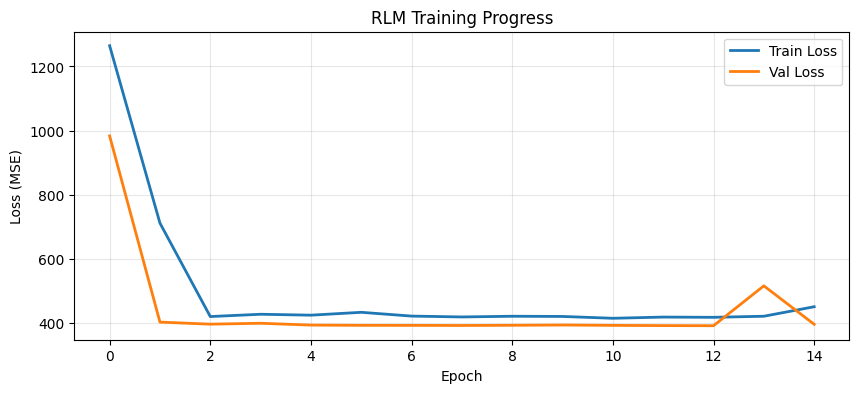


🎯 Testing Predictions:
------------------------------------------------------------
Input: The temperature is 25.5 degrees
Predicted value: 50.7752

Input: I rate this 8.0 out of ten
Predicted value: 50.7753

Input: The price is 45.0 dollars
Predicted value: 50.7752

Input: 75.0 percent complete
Predicted value: 1.7321

✅ RLM Tutorial Complete!


In [7]:
print("\n📝 Generating synthetic data...")
data = generate_synthetic_data(2000)
split_idx = int(0.8 * len(data))
train_data, val_data = data[:split_idx], data[split_idx:]
print(f"Train samples: {len(train_data)}, Val samples: {len(val_data)}")

print("\n🔤 Building tokenizer...")
tokenizer = SimpleTokenizer()
tokenizer.fit([text for text, _ in train_data])
print(f"Vocabulary size: {tokenizer.vocab_size}")

train_dataset = RLMDataset(train_data, tokenizer)
val_dataset = RLMDataset(val_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("\n🏗️ Building Regression Language Model...")
model = RegressionLanguageModel(vocab_size=tokenizer.vocab_size)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

train_losses, val_losses = train_rlm(model, train_loader, val_loader)

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('RLM Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n🎯 Testing Predictions:")
print("-" * 60)
test_examples = [
    "The temperature is 25.5 degrees",
    "I rate this 8.0 out of ten",
    "The price is 45.0 dollars",
    "75.0 percent complete"
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    for text in test_examples:
        tokens = torch.tensor([tokenizer.encode(text)]).to(device)
        prediction = model(tokens).item()
        print(f"Input: {text}")
        print(f"Predicted value: {prediction:.4f}\n")

print("✅ RLM Tutorial Complete!")